In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

mkdir: não foi possível criar o diretório “data/”: Arquivo existe
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1799k      0  0:00:06  0:00:06 --:--:-- 3409k
Archive:  data/animais.zip
replace data/animais/val/tatu/10242.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [16]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [17]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 1, Train Loss: 0.718, Train Accuracy: 47.50%
Epoch 1, Val Loss: 0.719, Val Accuracy: 43.44%


100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 2, Train Loss: 0.703, Train Accuracy: 52.25%
Epoch 2, Val Loss: 0.701, Val Accuracy: 52.46%


100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 3, Train Loss: 0.681, Train Accuracy: 57.50%
Epoch 3, Val Loss: 0.687, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Epoch 4, Train Loss: 0.683, Train Accuracy: 56.50%
Epoch 4, Val Loss: 0.674, Val Accuracy: 59.84%


100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 5, Train Loss: 0.686, Train Accuracy: 55.50%
Epoch 5, Val Loss: 0.693, Val Accuracy: 58.20%
Treinamento concluído


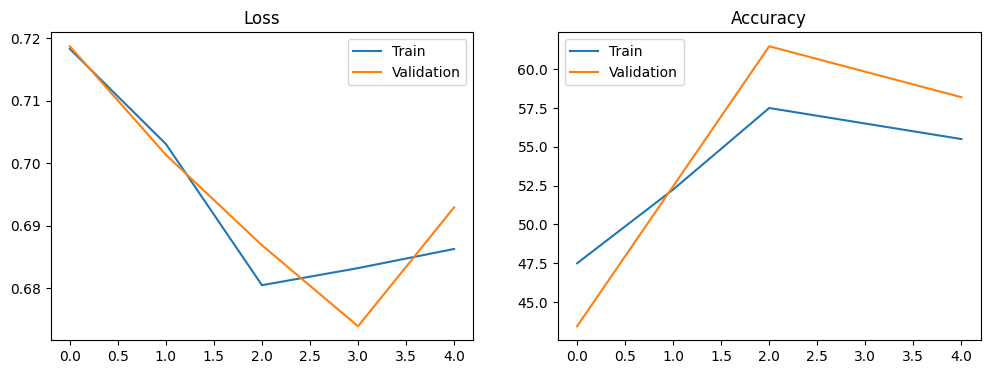

Acurácia da rede na base de teste: 58.20%


In [19]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [20]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [21]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [22]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


Epoch 1, Train Loss: 0.854, Train Accuracy: 41.50%
Epoch 1, Val Loss: 0.527, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 2, Train Loss: 0.457, Train Accuracy: 81.75%
Epoch 2, Val Loss: 0.233, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 3, Train Loss: 0.344, Train Accuracy: 85.75%
Epoch 3, Val Loss: 0.164, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch 4, Train Loss: 0.262, Train Accuracy: 89.25%
Epoch 4, Val Loss: 0.150, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Epoch 5, Train Loss: 0.278, Train Accuracy: 88.75%
Epoch 5, Val Loss: 0.132, Val Accuracy: 96.72%
Treinamento concluído


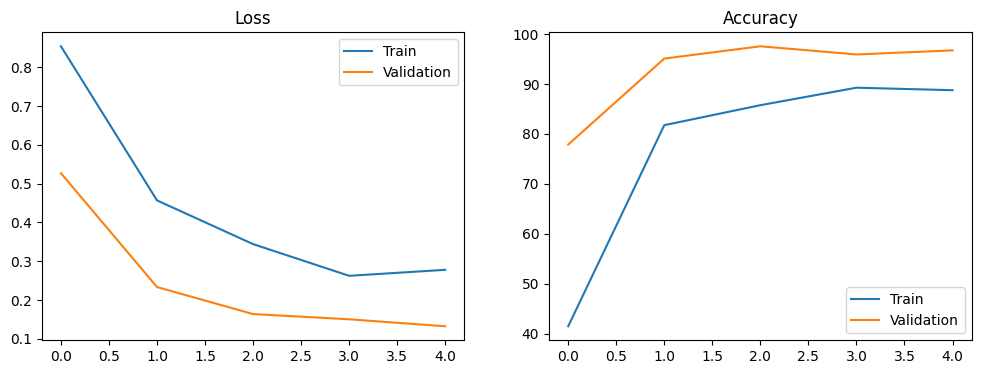

Acurácia da rede na base de teste: 96.72%


In [23]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [24]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

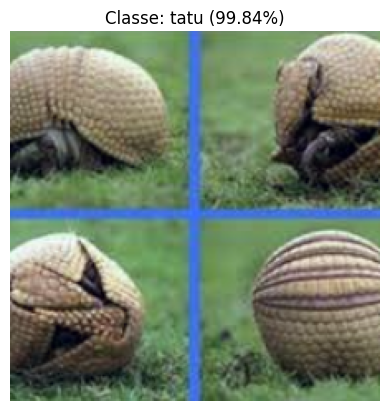

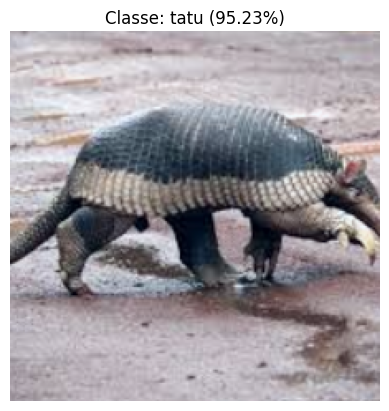

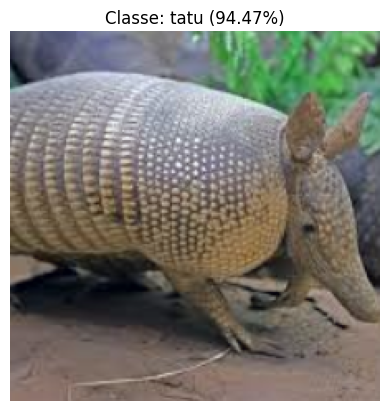

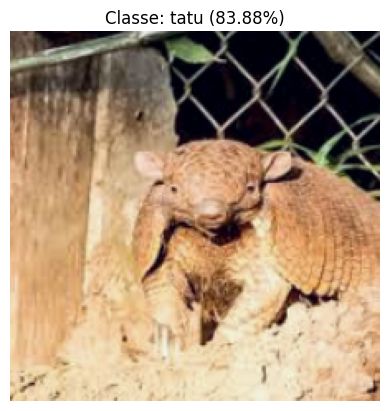

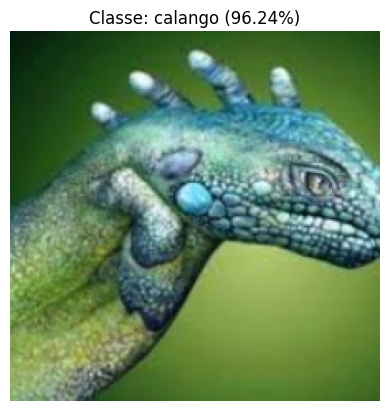

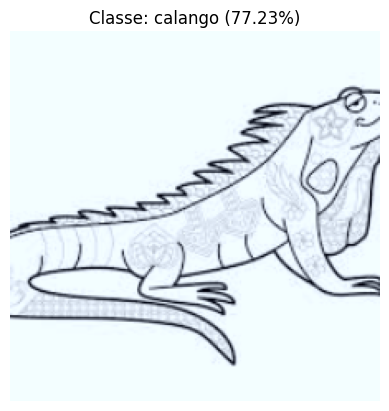

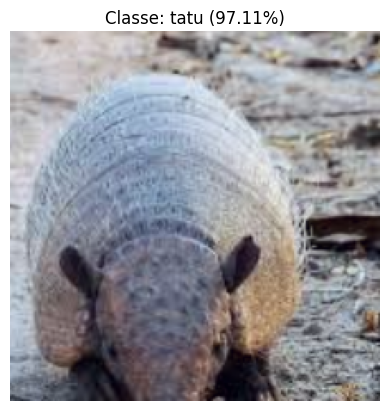

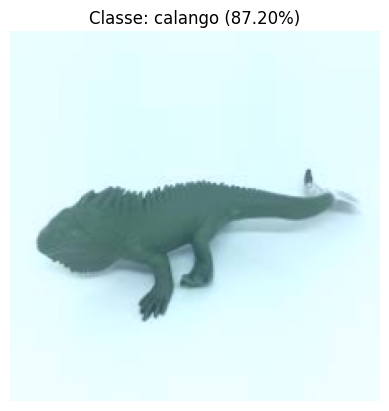

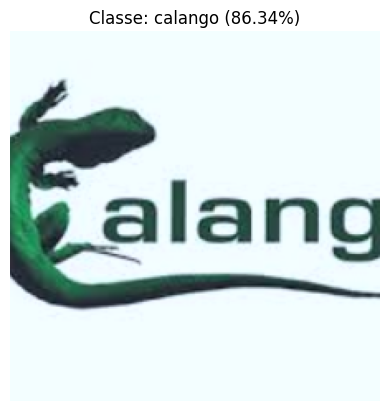

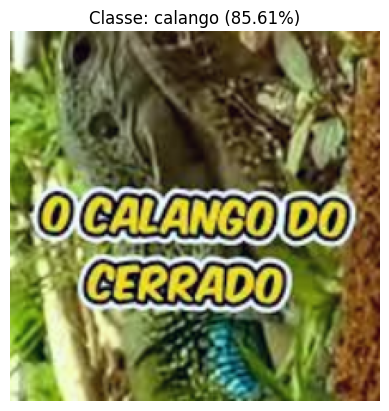

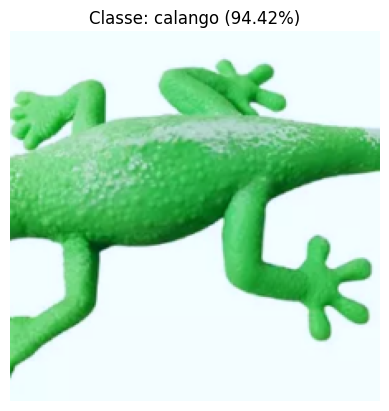

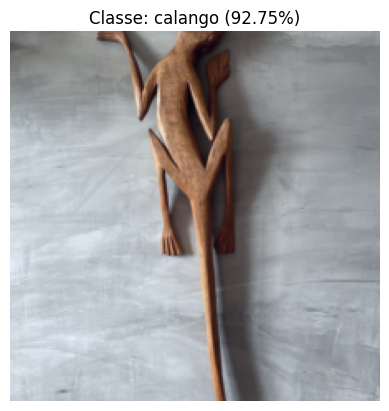

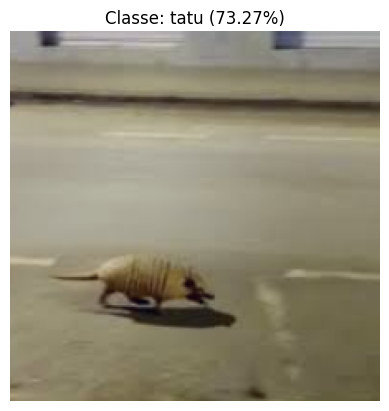

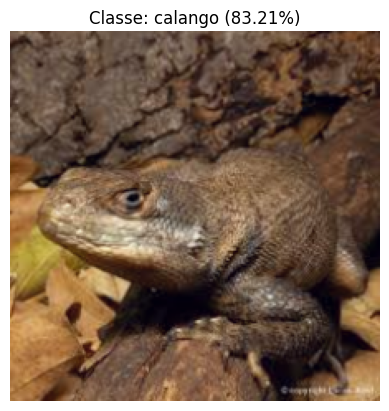

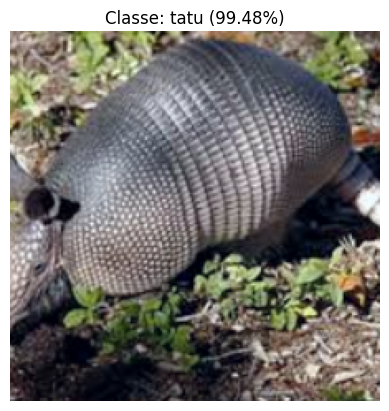

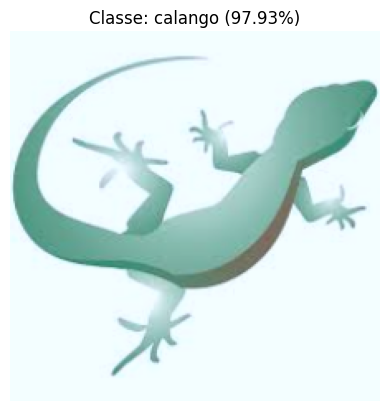

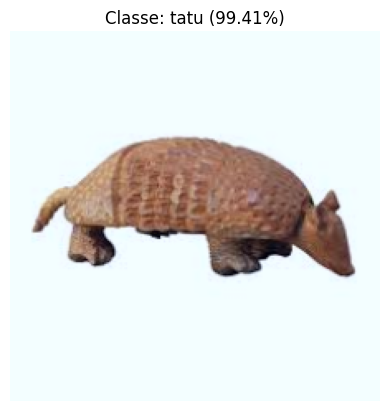

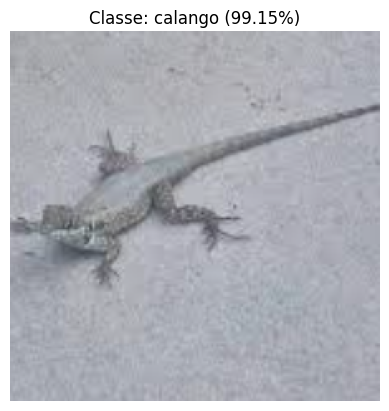

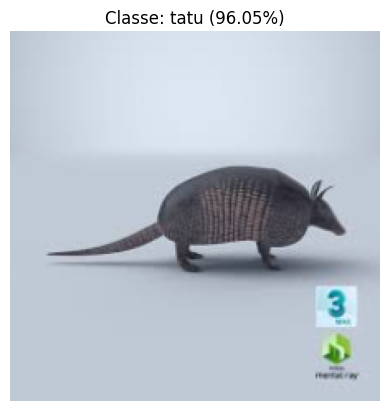

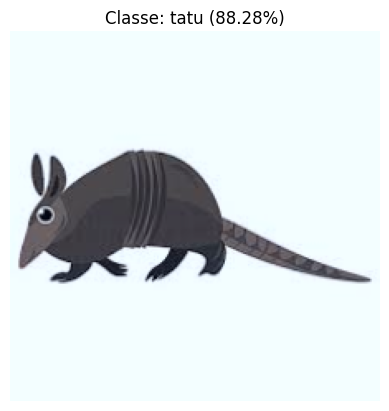

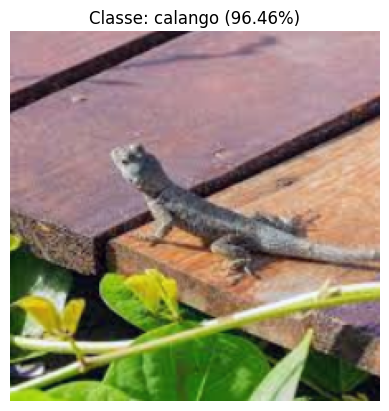

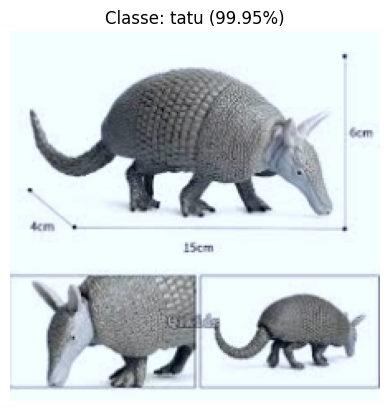

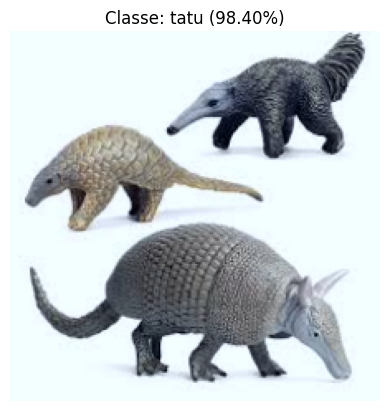

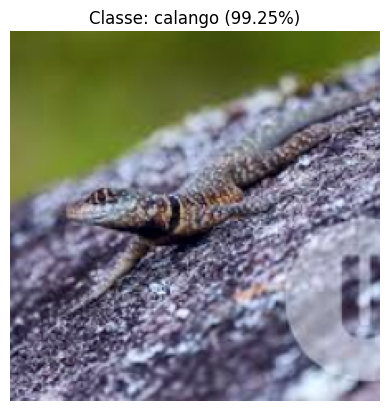

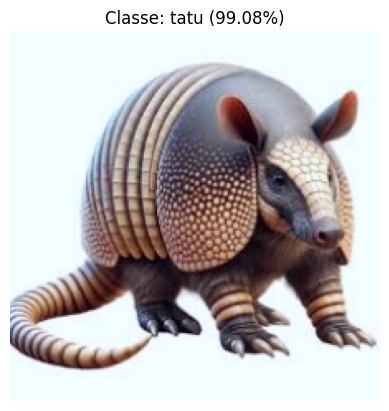

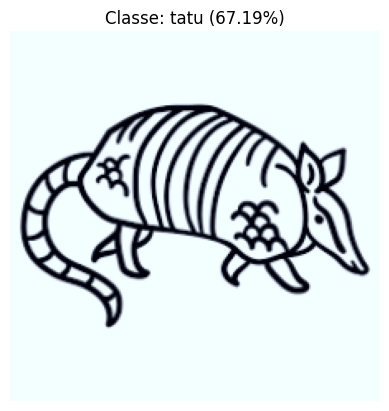

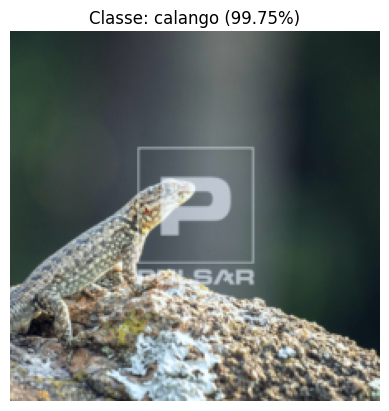

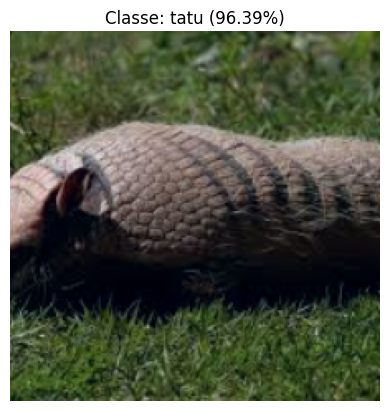

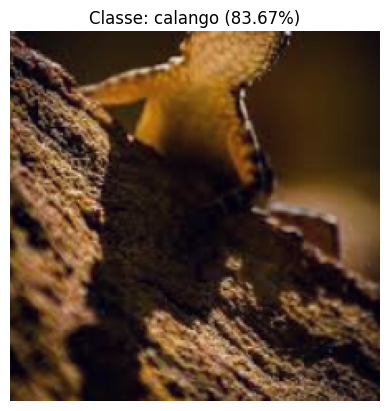

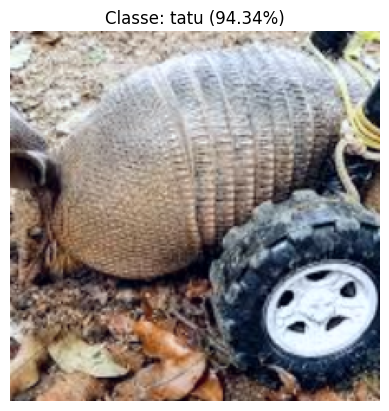

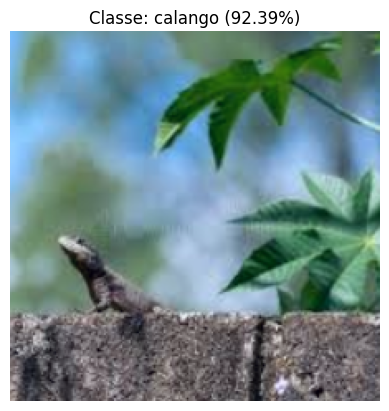

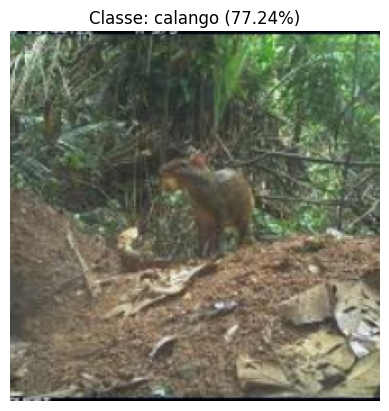

In [25]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 1, Train Loss: 0.180, Train Accuracy: 95.25%
Epoch 1, Val Loss: 0.142, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 2, Train Loss: 0.161, Train Accuracy: 93.75%
Epoch 2, Val Loss: 0.136, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


Epoch 3, Train Loss: 0.157, Train Accuracy: 95.25%
Epoch 3, Val Loss: 0.129, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 4, Train Loss: 0.165, Train Accuracy: 94.75%
Epoch 4, Val Loss: 0.132, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Epoch 5, Train Loss: 0.146, Train Accuracy: 94.25%
Epoch 5, Val Loss: 0.125, Val Accuracy: 94.26%
Treinamento concluído


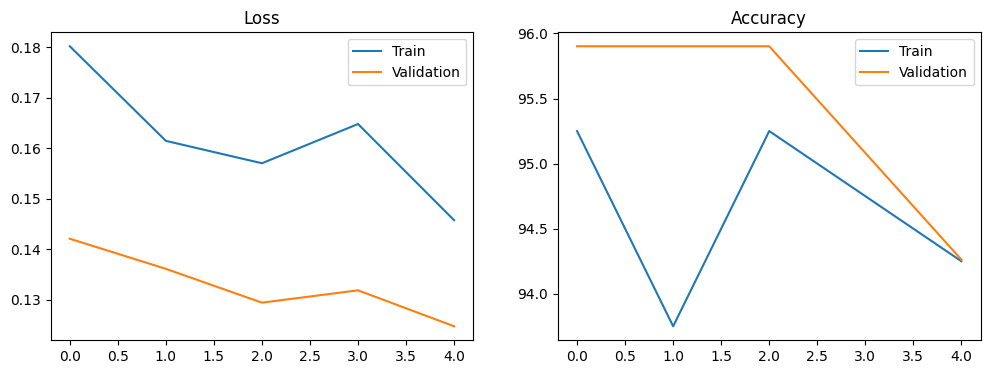

Acurácia da rede na base de teste: 94.26%


In [26]:
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)
val_loader_no_aug = DataLoader(val_set_no_aug, batch_size=32, shuffle=True)

# Treinando a CNN sem data augmentation
history_no_aug = train_model(model, train_loader_no_aug, val_loader_no_aug, criterion, optimizer, device, num_epochs=5)

# Plotando as curvas de treinamento
plot_history(history_no_aug)

# Testando a rede
test_model(model, val_loader_no_aug)

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [28]:
model = models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4[1].parameters():
  param.requires_grad = True

for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

history_unfreezed = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

test_model(model, val_loader)
print(test_model)

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 1, Train Loss: 10.690, Train Accuracy: 0.00%
Epoch 1, Val Loss: 12.018, Val Accuracy: 0.00%


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 2, Train Loss: 10.717, Train Accuracy: 0.00%
Epoch 2, Val Loss: 11.960, Val Accuracy: 0.00%


100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 3, Train Loss: 10.606, Train Accuracy: 0.00%
Epoch 3, Val Loss: 11.995, Val Accuracy: 0.00%


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch 4, Train Loss: 10.639, Train Accuracy: 0.00%
Epoch 4, Val Loss: 11.956, Val Accuracy: 0.00%


100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 5, Train Loss: 10.670, Train Accuracy: 0.00%
Epoch 5, Val Loss: 12.042, Val Accuracy: 0.00%
Treinamento concluído
Acurácia da rede na base de teste: 0.00%
<function test_model at 0x79b94b721d00>


### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.